In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor

In [118]:
file_path = "/Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_TNKI_65+yr.csv"
df = pd.read_csv(file_path)
group = file_path.split("\\")[-1].replace(".csv", "")

df = df.dropna().reset_index(drop=True)

drop_cols = ["day", "Count_all", "Count_cvd", "rate"]
features = [col for col in df.columns if col not in drop_cols]
X = df[features].values
y = df["rate"].values
#y = df["Count_cvd"].values

In [119]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [121]:
def regression_model_selection_grid(model, param_grid, X_train, y_train,
                                    X_val=None, y_val=None,
                                    scoring='r2', cv=5, verbose=1, n_jobs=-1):
    """
    Perform grid search hyperparameter tuning for any sklearn-compatible regression model.
    Includes boundary check warnings if best parameter is at grid edge.

    Parameters
    ----------
    model : estimator object
        Base model (e.g., Lasso(), SVR(), RandomForestRegressor(), XGBRegressor()).
    param_grid : dict
        Dictionary of hyperparameters and candidate values.
    X_train, y_train : array-like
        Training data.
    X_val, y_val : array-like, optional
        Optional validation data for evaluating final model performance.
    scoring : str, default='r2'
        Metric to optimize ('r2', 'neg_mean_squared_error', etc.).
    cv : int, default=5
        Number of cross-validation folds.
    verbose : int, default=1
        Verbosity level.
    n_jobs : int, default=-1
        Number of CPU cores to use (-1 = all cores).

    Returns
    -------
    best_model : fitted estimator
        Model trained with best parameters.
    best_params : dict
        Best hyperparameters found by GridSearchCV.
    best_score : float
        Best cross-validation score.
    """

    grid = GridSearchCV(model, param_grid, scoring=scoring,
                        cv=cv, verbose=verbose, n_jobs=n_jobs)
    grid.fit(X_train, y_train)

    print("\nBest Parameters:")
    print(grid.best_params_)
    print(f"Best Cross-validation {scoring}: {grid.best_score_:.4f}")

    for param, values in param_grid.items():
        if not isinstance(values, (list, tuple, np.ndarray)):
            continue  # skip if not iterable
        best_val = grid.best_params_.get(param)
        if best_val == values[0]:
            print(f"Warning: Best {param} = {best_val} is at the LOWER bound of search range.")
            print("   → Consider extending the range downward.")
        elif best_val == values[-1]:
            print(f"Warning: Best {param} = {best_val} is at the UPPER bound of search range.")
            print("   → Consider extending the range upward.")

    best_model = grid.best_estimator_

    if X_val is not None and y_val is not None:
        y_pred = best_model.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f"Validation R²: {r2:.4f}")
        print(f"Validation RMSE: {rmse:.4f}")

    return best_model, grid.best_params_, grid.best_score_

In [122]:
def plot_predicted_vs_true(y_true, y_pred, title="Predicted vs True Values"):
    """
    Plot the relationship between predicted and true values with a regression line.

    Parameters
    ----------
    y_true : array-like
        True target values.
    y_pred : array-like
        Predicted values.
    title : str
        Title for the plot.
    """

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    model = linear_model.LinearRegression()
    model.fit(y_true.reshape(-1, 1), y_pred)
    y_fit = model.predict(y_true.reshape(-1, 1))

    # Create scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolor='k', label='Data points')

    # Ideal y = x line
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
             'r--', label='Ideal: y = x')

    # Regression fit line
    plt.plot(y_true, y_fit, color='blue', linewidth=2,
             label=f'Fit: y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}')

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.xlim([0,0.5])
    plt.ylim([0,0.5])
    plt.title(f"{title}\nR²={r2:.3f}, RMSE={rmse:.3f}")
    #plt.legend()
    plt.grid(True)
    #plt.tight_layout()
    plt.show()

In [123]:

def moving_average(data, window_size=3, method='center'):
    """
    Compute the moving average (rolling mean) of a 1D array or pandas Series.
    Removes NaN values from the result.

    Parameters
    ----------
    data : array-like or pandas Series
        Input data (e.g., time-series values).
    window_size : int, default=3
        Number of points to include in each moving window.
    method : {'center', 'right', 'left'}, default='center'
        Window alignment:
            'center' → centered moving average
            'right'  → trailing average (uses past values)
            'left'   → forward average (uses future values)

    Returns
    -------
    ma : numpy.ndarray
        Smoothed values (moving average) with NaN values removed.
    """

    s = pd.Series(data)

    if method == 'center':
        ma = s.rolling(window=window_size, center=True).mean()
    elif method == 'right':
        ma = s.rolling(window=window_size, center=False).mean()
    elif method == 'left':
        ma = s[::-1].rolling(window=window_size, center=False).mean()[::-1]
    else:
        raise ValueError("method must be one of {'center', 'right', 'left'}")

    # Drop NaN values (remove incomplete windows)
    ma = ma.dropna()

    return ma.to_numpy()

In [124]:
param_grid_rf = {
    'max_depth': [5,10],
#    'n_estimators': [100, 200, 300],
#    'max_features': [10, 20 , 40, 80,120,160],
#    'min_samples_leaf': [1, 2, 4]
}
best_rf, best_params_rf, best_score_rf = regression_model_selection_grid(
    RandomForestRegressor(random_state=25, n_jobs=-1),
    param_grid_rf,
    X_train, y_train, verbose=3
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Parameters:
{'max_depth': 10}
Best Cross-validation r2: 0.6178
⚠️  Warning: Best max_depth = 10 is at the UPPER bound of search range.
   → Consider extending the range upward.


In [125]:
y_pred = best_rf.predict(X_test)
r2_score(y_test, y_pred)

0.628706141509476

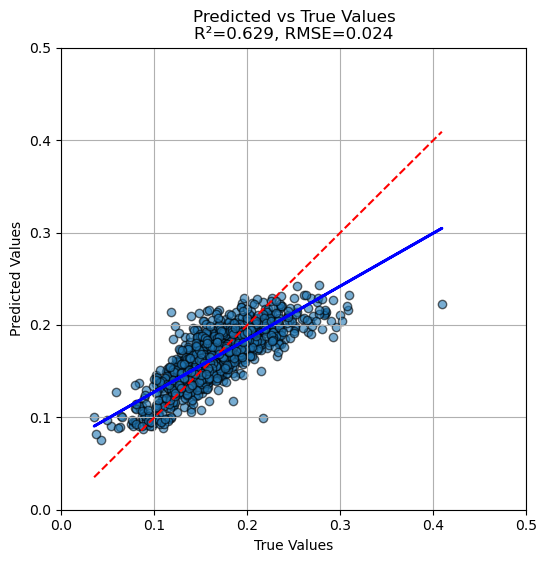

In [127]:
plot_predicted_vs_true(y_test, y_pred)

<Axes: >

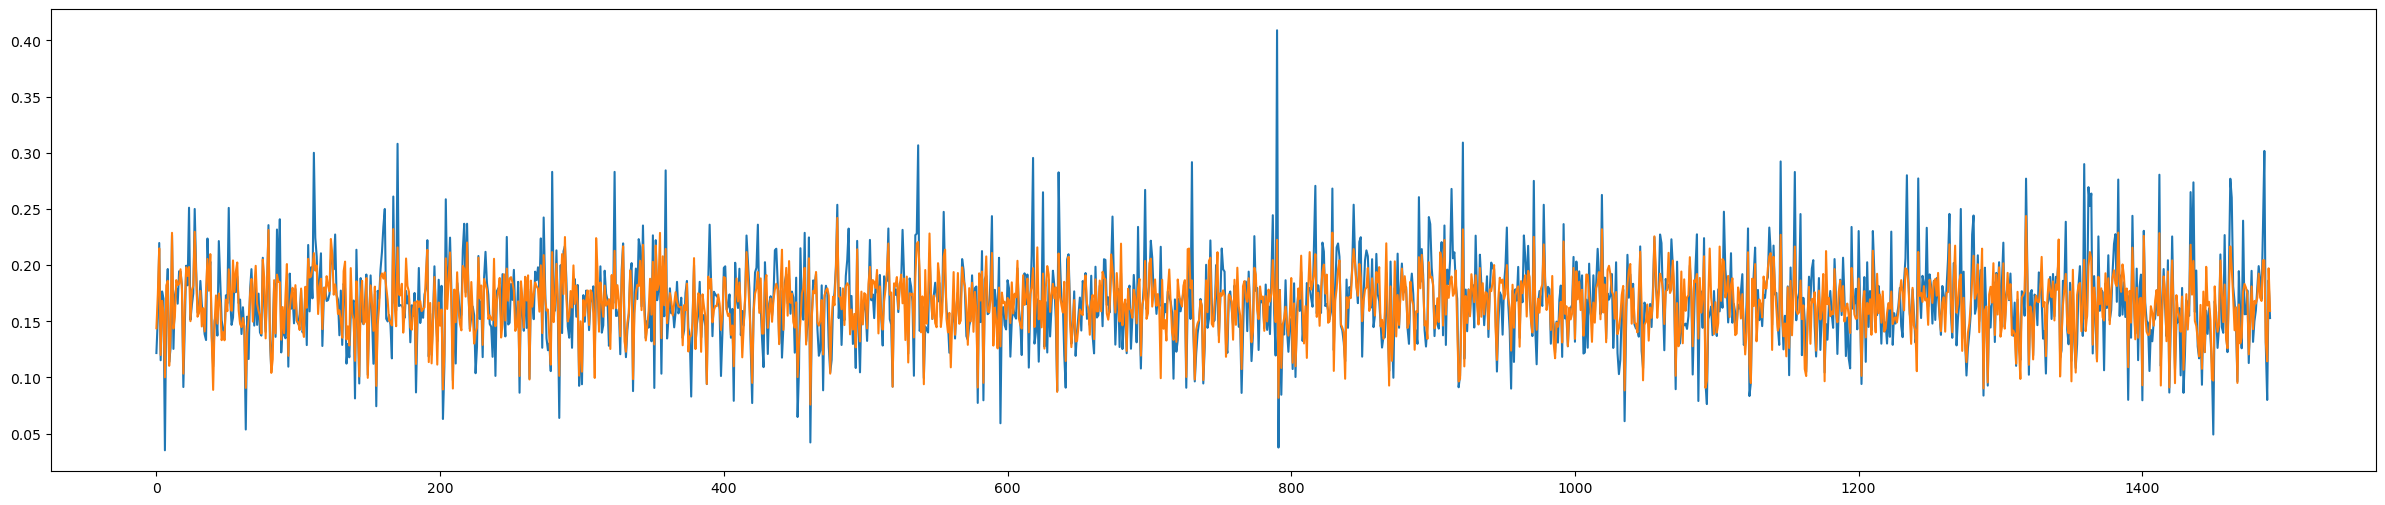

[CV 3/5] END .....max_depth=10, max_features=20;, score=0.551 total time=  14.8s
[CV 4/5] END .....max_depth=20, max_features=80;, score=0.555 total time=  53.2s
[CV 5/5] END ......max_depth=5, max_features=40;, score=0.450 total time=  15.6s
[CV 5/5] END .....max_depth=20, max_features=80;, score=0.588 total time=  53.2s
[CV 5/5] END .....max_depth=5, max_features=160;, score=0.486 total time=  19.0s
[CV 4/5] END .....max_depth=25, max_features=10;, score=0.483 total time=  22.2s
[CV 1/5] END .....max_depth=30, max_features=20;, score=0.559 total time=  26.1s
[CV 1/5] END .....max_depth=15, max_features=40;, score=0.582 total time=  20.2s
[CV 5/5] END .....max_depth=25, max_features=10;, score=0.520 total time=  22.2s
[CV 2/5] END .....max_depth=30, max_features=20;, score=0.552 total time=  26.0s
[CV 4/5] END .....max_depth=10, max_features=20;, score=0.501 total time=  11.0s
[CV 4/5] END ....max_depth=15, max_features=120;, score=0.561 total time=  58.4s
[CV 2/5] END ......max_depth

In [128]:
plt.figure(figsize=(30, 6))
sns.lineplot(y_test)
sns.lineplot(y_pred)

In [14]:
results = {}
models = {}

# === 1. SVR ===
svm = SVR(kernel="rbf", C=10, epsilon=0.003)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
results["SVR"] = r2_score(y_test, y_pred)
models["SVR"] = svm

# === 2. Ridge ===
ridge = Ridge(alpha=0.01, random_state=42)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
results["Ridge"] = r2_score(y_test, y_pred)
models["Ridge"] = ridge

# === 3. Lasso ===
lasso = Lasso(random_state=42)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
results["Lasso"] = r2_score(y_test, y_pred)
models["Lasso"] = lasso

# === 4. LightGBM ===
lgb_model = lgb.LGBMRegressor(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
results["LightGBM"] = r2_score(y_test, y_pred)
models["LightGBM"] = lgb_model

# === 5. XGBoost ===
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
results["XGBoost"] = r2_score(y_test, y_pred)
models["XGBoost"] = xgb_model

# === 6. Random Forest ===
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
results["RandomForest"] = r2_score(y_test, y_pred)
models["RandomForest"] = rf_model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44397
[LightGBM] [Info] Number of data points in the train set: 5963, number of used features: 184
[LightGBM] [Info] Start training from score 0.164708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Group16T/common/chenh2/miniconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [15]:
# === 顯示 R² ===
print(f"=== {group} 各模型 R² 結果 ===")
for model_name, r2 in results.items():
    print(f"{model_name}: {r2:.4f}")

=== /Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_TNKI_65+yr 各模型 R² 結果 ===
SVR: 0.5319
Ridge: 0.5784
Lasso: -0.0018
LightGBM: 0.6467
XGBoost: 0.6125
RandomForest: 0.6300


In [8]:
# === 顯示 R² ===
print(f"=== {group} 各模型 R² 結果 ===")
for model_name, r2 in results.items():
    print(f"{model_name}: {r2:.4f}")

=== /Group16T/common/chenh2/NTNU_ES_data/ER_data_new/Merged_TNKI_65+yr 各模型 R² 結果 ===
SVR: 0.5238
Ridge: 0.5788
Lasso: 0.5179
LightGBM: 0.6442
XGBoost: 0.6153
RandomForest: 0.6330


In [9]:
# === 建立 SHAP 圖 ===
for name, model in models.items():
    print(f"\n🔍 正在產生 {name} 的 SHAP 圖...")

    try:
        if name in ["LightGBM", "XGBoost", "RandomForest"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20, show=False)
        
        elif name in ["Ridge", "Lasso"]:
            explainer = shap.LinearExplainer(model, X_train_scaled if name == "Lasso" else X_train)
            shap_values = explainer.shap_values(X_test_scaled if name == "Lasso" else X_test)
            shap.summary_plot(shap_values, X_test_scaled if name == "Lasso" else X_test, feature_names=features, max_display=20, show=False)

        elif name == "SVR":
            # 取小部分樣本避免太慢
            sample_idx = np.random.choice(len(X_test), size=min(200, len(X_test)), replace=False)
            explainer = shap.KernelExplainer(model.predict, X_train[:100])
            shap_values = explainer.shap_values(X_test[sample_idx], nsamples=100)
            shap.summary_plot(shap_values, X_test[sample_idx], feature_names=features, max_display=20, show=False)
        
        plt.title(f"Top 20 SHAP Features - {group} ({name})")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠ {name} SHAP 計算失敗：{e}")


🔍 正在產生 SVR 的 SHAP 圖...


 12%|█████▎                                    | 25/200 [03:13<22:31,  7.73s/it]


KeyboardInterrupt: 